# PSF modelling

In [308]:
#@title Import packages

import numpy as np
import scipy.signal as spsig
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL
import time
from tqdm.notebook import tqdm

%pylab inline
plt.rcParams['figure.figsize'] = (16, 8)


%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

Populating the interactive namespace from numpy and matplotlib
Found GPU at: /device:GPU:0
2.4.0


In [309]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define building blocks

In [310]:
#@title SimPSFToolkit definition

class SimPSFToolkit(object):
    """Simulate PSFs.
    
    In the future the zernike maps could be created with galsim.
    
    Parameters
    ----------
    zernike_maps
    pad_factor=2
    max_order=45
    max_wfe: float
        Maximum allowed WFE at ``lambda_norm``. Used for
        normalization. Units in [\mu m].
        Default is ``0.1``.
    lambda_norm: float
        Corresponds to the wavelength at which the normalization 
        of the WFE is taking place. Units in [\mu m].
        Default is ``0.550``.
    rand_seed=None
    plot_opt=True
    
    """
    
    def __init__(self, zernike_maps, max_order=45, max_wfe_rms=0.1,
                 output_dim=64, rand_seed=None, plot_opt=False, oversampling_rate=2,
                 pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5,
                 pupil_diameter=1024, euclid_obsc=True, LP_filter_length=3, verbose=0):
        # Input attributes
        self.max_order = max_order
        self.rand_seed = rand_seed
        self.plot_opt = plot_opt
        self.zernike_maps = zernike_maps
        self.max_wfe_rms = max_wfe_rms  # In [um]
        self.output_dim = output_dim  # In pixels per dimension
        self.verbose = verbose
        
        
        # Telescope characteristics
        self.oversampling_rate = oversampling_rate  # dimensionless
        self.pix_sampling = pix_sampling  # In [um]
        self.tel_diameter = tel_diameter  # In [m]
        self.tel_focal_length = tel_focal_length  # In [m]
        self.pupil_diameter = pupil_diameter  # In [pix]
        
        # Class attributes
        self.z_coeffs = None
        self.psf = None
        self.opd = None
        self.phase = None
        self.lambda_obs = None
        self.poly_psf = None
        
        # Generate pupil mask
        self.pupil_mask = ~np.isnan(self.zernike_maps[0])
        
        # Generate obscurations
        if euclid_obsc:
            self.obscurations = self.generate_pupil_obscurations(N_pix=pupil_diameter, N_filter=LP_filter_length)
        else:
            self.obscurations = np.ones((pupil_diameter, pupil_diameter))    
        
        
    @staticmethod
    def _OLD_fft_diffraction_op(wf, pupil_mask, pad_factor=2, match_shapes=True):
        """ Perform a fft-based diffraction.

        Parameters
        ----------
        wf: np.ndarray
            A complex 2D array that corresponds to the wavefront function.
        pupil_mask: np.ndarray of bools
            A 2D boolean mask that corresponds to the pupil function.


        Returns
        -------
        psf: np.ndarray
            A real 2D array corresponding to the PSF.

        """
        start = (wf.shape[0]*pad_factor)//2 - wf.shape[0]//2
        stop = (wf.shape[0]*pad_factor)//2 + wf.shape[0]//2

        padded_wf = np.zeros((wf.shape[0]*pad_factor, wf.shape[1]*pad_factor), dtype=np.complex128)

        padded_wf[start:stop, start:stop][pupil_mask] = wf[pupil_mask]

        fft_wf = np.fft.fftshift(np.fft.fft2(padded_wf))
        # fft_wf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_wf)))
        
        psf = np.abs(fft_wf)**2
        
        if match_shapes:
            # Return the psf with its original shape without the padding factor
            x_dif = int((psf.shape[0]/pad_factor)//2)
            y_dif = int((psf.shape[1]/pad_factor)//2)        

            return psf[x_dif :psf.shape[0]-x_dif, y_dif :psf.shape[1]-y_dif]
        else:
            return psf
    
    
    @staticmethod
    def fft_diffract(wf, output_dim=64):
        # Perform the FFT-based diffraction operation
        fft_wf = np.fft.fftshift(np.fft.fft2(wf))
        psf = np.abs(fft_wf)**2
        
        # Crop the image
        start = int(psf.shape[0]//2-output_dim//2)
        stop = int(psf.shape[0]//2+output_dim//2)        

        return psf[start:stop, start:stop]

    @staticmethod
    def generate_pupil_obscurations(N_pix=1024, N_filter=3):
        """Generate Euclid like pupil obscurations.

        Simple procedure considering only the 2D plane.
        No 3D projections wrt the angle of the FoV is done.

        Parameters
        ----------
        N_pix: int
            Total number of pixels
        N_filter: int
            Length of the low-pass filter [pixels]

        """
        # Telescope parameters
        AS_diam = 1200  # Aperture stop diameter [mm]
        M1_diam = 395  # Mirror 1 cap stopper diameter [mm]

        sp_lenght = 700  # Spider length [mm]
        sp_width = 12  # Spider width [mm] 

        AS_centre = [0, 0]
        M1_centre = [0, 51]

        sp1_angle = 106.78 - 90 # [degrees]
        sp2_angle = 50.11 - 90 # [degrees]
        sp3_angle = -10.76 - 90 # [degrees]

        sp1_x_pos = 260  # [mm]
        sp1_y_pos = 240  # [mm]
        sp2_x_pos = -330  # [mm]
        sp2_y_pos = 130  # [mm]
        sp3_x_pos = 70  # [mm]
        sp3_y_pos = -330  # [mm]


        # Build pupil plane
        pupil_plane = np.ones((N_pix, N_pix))

        # coordinates of map in [mm]
        W, H  = np.meshgrid(np.linspace(-AS_diam//2, AS_diam//2, N_pix), np.linspace(-AS_diam//2, AS_diam//2, N_pix)) 


        ### Calculate the Aperture stop and draw it ###
        aperture_stop_mask = np.sqrt((W - AS_centre[0])**2 + (H - AS_centre[1])**2) <= (AS_diam/2) 
        pupil_plane[~aperture_stop_mask] = 0


        ### Calculate the M1/M2 obscurations and draw them ###
        M1_mask = np.sqrt((W - M1_centre[0])**2 + (H - M1_centre[1])**2) <= (M1_diam/2)
        pupil_plane[M1_mask] = 0


        ### Calculate the spiders and draw them ###

        # Spider 1
        sp1_a = np.tan(sp1_angle*(np.pi/180))
        sp1_b = sp1_y_pos - sp1_a*sp1_x_pos

        sp1_mask_1 = sp1_a*W + sp1_b - sp_width/2 * np.sqrt(1 + sp1_a**2) < H
        sp1_mask_2 = sp1_a*W + sp1_b + sp_width/2 * np.sqrt(1 + sp1_a**2) > H
        sp1_mask = np.logical_and(sp1_mask_1, sp1_mask_2)

        sp1_length_mask = np.sqrt((W - sp1_x_pos)**2 + (H - sp1_y_pos)**2) <= (sp_lenght/2)
        sp1_mask = np.logical_and(sp1_mask, sp1_length_mask)

        # Spider 2
        sp2_a = np.tan(sp2_angle*(np.pi/180))
        sp2_b = sp2_y_pos - sp2_a*sp2_x_pos

        sp2_mask_1 = sp2_a*W + sp2_b - sp_width/2 * np.sqrt(1 + sp2_a**2) < H
        sp2_mask_2 = sp2_a*W + sp2_b + sp_width/2 * np.sqrt(1 + sp2_a**2) > H
        sp2_mask = np.logical_and(sp2_mask_1, sp2_mask_2)

        sp2_length_mask = np.sqrt((W - sp2_x_pos)**2 + (H - sp2_y_pos)**2) <= (sp_lenght/2)
        sp2_mask = np.logical_and(sp2_mask, sp2_length_mask)

        # Spider 3
        sp3_a = np.tan(sp3_angle*(np.pi/180))
        sp3_b = sp3_y_pos - sp3_a*sp3_x_pos

        sp3_mask_1 = sp3_a*W + sp3_b - sp_width/2 * np.sqrt(1 + sp3_a**2) < H
        sp3_mask_2 = sp3_a*W + sp3_b + sp_width/2 * np.sqrt(1 + sp3_a**2) > H
        sp3_mask = np.logical_and(sp3_mask_1, sp3_mask_2)

        sp3_length_mask = np.sqrt((W - sp3_x_pos)**2 + (H - sp3_y_pos)**2) <= (sp_lenght/2)
        sp3_mask = np.logical_and(sp3_mask, sp3_length_mask)

        # Draw the three spider arms
        pupil_plane[sp1_mask] = 0
        pupil_plane[sp2_mask] = 0
        pupil_plane[sp3_mask] = 0


        ### Low-pass filter the image ###
        top_hat_filter = np.ones((N_filter, N_filter))

        pupil_plane = spsig.convolve2d(
        pupil_plane, top_hat_filter, boundary='fill', mode='same', fillvalue=0)

        pupil_plane /= np.sum(top_hat_filter)

        return pupil_plane
    
    
    @staticmethod
    def crop_img(to_crop_img, ref_im):
        cent_x = int(to_crop_img.shape[0]//2)
        cent_y = int(to_crop_img.shape[1]//2)
        
        delta_x = int(ref_im.shape[0]//2)
        delta_y = int(ref_im.shape[1]//2)
        
        return to_crop_img[ cent_x-delta_x : cent_x+delta_x , cent_y-delta_y : cent_y+delta_y ]
        
    
    @staticmethod
    def decimate_im(input_im, decim_f):
        """Decimate image.
        
        Decimated by a factor of decim_f.
        Based on the PIL library using the default interpolator.
        
        """

        pil_im = PIL.Image.fromarray(input_im)
        (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
        im_resized = pil_im.resize((width, height))

        return np.array(im_resized)
    
    
    @staticmethod
    def get_radial_idx(max_order=45):
        it=1
        radial_idxs = []

        while(len(radial_idxs)<=max_order):
            for _it in range(it):
                radial_idxs.append(it-1)

            it+=1

        return np.array(radial_idxs)

    
    @staticmethod
    def psf_plotter(psf, lambda_obs=0.000, cmap='gist_stern', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(psf, cmap=cmap, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_xticks([]);ax1.set_yticks([])
        ax1.set_title('PSF (lambda=%.3f [um])'%(lambda_obs))

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(np.sqrt(abs(psf)), cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('sqrt PSF (lambda=%.3f [um])'%(lambda_obs))
        ax2.set_xticks([]);ax2.set_yticks([])

        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.log(abs(psf)), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('log PSF (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./PSF_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    @staticmethod
    def opd_phase_plotter(pupil_mask, opd, phase, lambda_obs, cmap='viridis', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(pupil_mask, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Pupil mask')
        ax1.set_xticks([]);ax1.set_yticks([])

        vmax = np.max(abs(opd))
        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(opd, cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('OPD [um]')
        ax2.set_xticks([]);ax2.set_yticks([])
        
        vmax = np.max(abs(np.angle(phase)))
        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.angle(phase), cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('W phase [rad](wv=%.2f[um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./OPD_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    def get_psf(self):
        if self.psf is not None:
            return self.psf
        else:
            print('No PSF has been computed yet.')

            
    def plot_psf(self, cmap='gist_stern', save_img=False):
        if self.psf is not None:
            self.psf_plotter(self.psf,self.lambda_obs, cmap, save_img)
        else:
            print('No PSF has been computed yet.')

            
    def plot_opd_phase(self, cmap='viridis', save_img=False):
        if self.opd is not None:
            self.opd_phase_plotter(self.pupil_mask*self.obscurations,
                                   self.opd*self.obscurations,
                                   self.phase, self.lambda_obs,
                                   cmap, save_img)
        else:
            print('No WF has been computed yet.')

            
    def gen_random_Z_coeffs(self, max_order=45, rand_seed=None):
        """ Generate a random set of Zernike coefficients.

        The coefficients are generated following a uniform law U~[-1,1] 
        divided by their radial zernike index. 
        Ex: u_i / r(i) (u_i is a realization of U)

        Parameters
        ----------
        max_order: int
            Maximum order of Zernike polynomials.
        rand_seed: int
            Seed for the random initialization.

        Returns
        -------
        rand_coeffs: list of floats
            List containing the random coefficients.

        """
        if rand_seed is not None:
            np.random.seed(rand_seed)

        rad_idx = self.get_radial_idx(max_order)
        rad_idx[0] = 1 
        
        z_coeffs = []

        for it in range(max_order):
            z_coeffs.append((np.random.rand()-0.5)*2./rad_idx[it])

        self.z_coeffs = z_coeffs

        
    def plot_z_coeffs(self, save_img=False):
        """Plot random Zernike coefficients."""
        if self.z_coeffs is not None:
            fig = plt.figure(figsize=(12,6))
            ax1 = fig.add_subplot(111)
            im1 = ax1.bar(np.arange(len(self.z_coeffs)), np.array(self.z_coeffs))
            ax1.set_xlabel('Zernike coefficients')
            ax1.set_ylabel('Magnitude')
            
            if save_img:
                plt.savefig('./Z_coeffs.pdf', bbox_inches='tight')
                
            plt.show()
        else:
            print('Random coeffs not generated.')
          

    def get_z_coeffs(self):
        """Get random coefficients"""
        if self.z_coeffs is not None:
            return self.z_coeffs
        else:
            print('Random coeffs not generated.')

            
    def set_z_coeffs(self, z_coeffs):
        """Set zernike coefficients."""
        if len(z_coeffs) == self.max_order:
            self.z_coeffs = z_coeffs
        else:
            print('Zernike coefficients should be of length %d'%(self.max_order))
     
    
    def normalize_zernikes(self, z_coeffs=None, max_wfe_rms=None):
        """Normalize zernike coefficients."""
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
            
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        mult_factor = max_wfe_rms / wfe_rms
        
        # Normalize Zernike coefficients and return them
        z_coeffs = [_z*mult_factor for _z in z_coeffs]
        
        return z_coeffs
    
    def calculate_wfe_rms(self, z_coeffs=None):
        """Calculate WFE rms from a set of zernike coefficients."""
        if z_coeffs is None:
            if self.z_coeffs is None:
                self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
                z_coeffs = self.get_z_coeffs()
            else:
                z_coeffs = self.get_z_coeffs()
                  
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Proyect obscurations on to the OPD
        opd *= self.obscurations
        
        # Calculate normalization factor
        wfe_rms = np.sqrt(np.mean((opd[self.pupil_mask] -np.mean(opd[self.pupil_mask]))**2))
        
        return wfe_rms
    
    def check_wfe_rms(self, z_coeffs=None, max_wfe_rms=None):
        """Check if Zernike coefficients are within the maximum admitted error."""
        
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
        
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        
        return max_wfe_rms - wfe_rms
        
        
    def generate_mono_PSF(self, lambda_obs=0.725, regen_sample=False, get_psf=False):
        """Generate monochromatic PSF."""
        if lambda_obs<0.55*0.95 or lambda_obs>0.9*0.95:
            print('WARNING: requested wavelength %.4f um is not in VIS passband [0.55,0.9]um'%(lambda_obs))
        self.lambda_obs = lambda_obs
        
        # Calculate the OPD from the Zernike coefficients
        self.calculate_opd(regen_sample)
          
        # Apply the diffraction operator using the opd (optical path differences)
        self.diffract_phase()
        
        if get_psf is True:
            return np.copy(self.psf)
    
    def calculate_opd(self, regen_sample=False):
        """Calculate the OPD from the Zernike coefficients."""
        if self.z_coeffs is None or regen_sample is True:
            # Generate a random sample of coefficients
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            # Normalize coefficients
            z_coeffs = self.normalize_zernikes(self.get_z_coeffs(), self.max_wfe_rms)
            # Save coefficients
            self.set_z_coeffs(z_coeffs)  
            # Plot Zernike coefficients
            if self.plot_opt:
                self.plot_z_coeffs()

        else:
            # Get the stored Zernike coefficients
            z_coeffs = self.get_z_coeffs()
            
        
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Save the wavefront
        self.opd = opd
        
    
    def diffract_phase(self, lambda_obs=None):
        """Diffract the phase map."""
        if lambda_obs is None:
            if self.lambda_obs is None:
                print('WARNING: No wavelength is defined. Using default value 0.8um.')
                lambda_obs = 0.8
            else: 
                lambda_obs = self.lambda_obs
        elif lambda_obs<0.55*0.99 or lambda_obs>0.9*1.01:
            print('WARNING: wavelength %.4f is not in VIS passband [0.55,0.9]um'%(lambda_obs))
            
        # Calculate the feasible lambda closest to lambda_obs
        possible_lambda = self.feasible_wavelength(lambda_obs)
        
        # Save wavelength
        self.lambda_obs = possible_lambda
        
        # Calculate the required N for the input lambda_obs
        possible_N = self.feasible_N(self.lambda_obs)
        
        # Generate the full phase and
        # Add zeros to the phase to have the correct fourier sampling
        start = possible_N//2 - self.opd.shape[0]//2
        stop = possible_N//2 + self.opd.shape[0]//2

        self.phase = np.zeros((possible_N, possible_N), dtype=np.complex128)
        self.phase[start:stop, start:stop][self.pupil_mask] = np.exp(
            2j*np.pi*self.opd[self.pupil_mask]/self.lambda_obs)
        
        # Project obscurations to the phase
        self.phase[start:stop, start:stop] *= self.obscurations
        
        # FFT-diffract the phase (wavefront) and then crop to desired dimension
        self.psf = self.fft_diffract(wf=self.phase, output_dim=self.output_dim)
        
        # Normalize psf
        self.psf /= np.sum(self.psf)

        
    def feasible_N(self, lambda_obs):
        """Calculate the feasible N for a lambda_obs diffraction.
        
        Input wavelength must be in [um].
        """
        # Calculate the required N for the input lambda_obs
        req_N = (
            self.oversampling_rate * self.pupil_diameter * lambda_obs * self.tel_focal_length)/ (
            self.tel_diameter * self.pix_sampling)
        # Recalculate the req_N into a possible value (a pair integer)
        possible_N = int((req_N//2)*2)
        
        return possible_N
    
    def feasible_wavelength(self, lambda_obs):
        """Calculate closest fesible wavelength to target wavelength.
        
        Input wavelength must be in [um].
        """
        # Calculate a feasible N for the input lambda_obs
        possible_N = self.feasible_N(lambda_obs)
        
        # Recalculate the corresponding the wavelength
        possible_lambda = (
            possible_N * self.tel_diameter * self.pix_sampling) / (
            self.pupil_diameter * self.oversampling_rate * self.tel_focal_length)
        
        if self.verbose > 0:
            print("Requested wavelength: %.5f \nRequired N: %.2f"%(lambda_obs, req_N))
            print("Possible wavelength: %.5f \nPossible N: %.2f"%(possible_lambda, possible_N))
            
        return possible_lambda
 
    
    @staticmethod
    def gen_SED_interp(SED, n_bins=35, interp_kind='cubic'):
        """Generate SED interpolator.
        
        Returns the interpolator and the wavelengths in [nm].
        """
        wv_max = 900
        wv_min = 550
        wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))
        
        SED_interp = sinterp.interp1d(
            SED[:,0], SED[:,1], kind=interp_kind, bounds_error=False, fill_value="extrapolate")
        
        return wvlength, SED_interp
    
    def calc_SED_wave_values(self, SED, n_bins=35):
        """Calculate feasible wavelength and SED values.
        
        Feasable so that the padding number N is integer.
        """
        # Generate SED interpolator and wavelength array
        wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
        
        # Convert wavelength from [nm] to [um]
        wvlength_um = wvlength/1e3
        
        # Calculate feasible wavelengths (in [um])
        verbose = self.verbose
        self.verbose = 0
        feasible_wv = np.array([self.feasible_wavelength(_wv) for _wv in wvlength_um])
        self.verbose = verbose
        
        # Interpolate and normalize SED
        SED_norm = SED_interp(feasible_wv*1e3)  # Interpolation is done in [nm] 
        SED_norm /= np.sum(SED_norm)        
        
        return feasible_wv, SED_norm
 

    def generate_poly_PSF(self, SED, n_bins=35):
        """Generate polychromatic PSF with a specific SED.
        
        The wavelength space will be the Euclid VIS instrument band:
        [550,900]nm and will be sample in ``n_bins``.
        
        """
        # Calculate the feasible values of wavelength and the corresponding
        # SED interpolated values
        feasible_wv, SED_norm = self.calc_SED_wave_values(SED, n_bins)   
        
        if self.plot_opt:
            # Plot input SEDs and interpolated SEDs
            wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
            
            fig = plt.figure(figsize=(14,8))
            ax1 = fig.add_subplot(111)
            ax1.plot(SED[:,0],SED[:,1], label='Input SED')
            ax1.scatter(feasible_wv*1e3, SED_interp(feasible_wv*1e3), label='Interpolated', c='red')
            ax1.set_xlabel('wavelength [nm]')
            ax1.set_ylabel('SED(wavelength)')
            ax1.set_title('SED')
            ax1.legend()
            # plt.savefig(output_path+'SED_interp_nbin_%d.pdf'%n_bins, bbox_inches='tight')
            plt.show()
        
        stacked_psf = 0
        
        # Generate the required monochromatic PSFs
        for it in range(feasible_wv.shape[0]):          
            self.generate_mono_PSF(lambda_obs=feasible_wv[it])
            stacked_psf += self.get_psf()*SED_norm[it]
           
        self.poly_psf = stacked_psf
        
        return stacked_psf

    
# This pythonic version of the polychromatic calculation is not working
# The parallelisation with the class with shared variables might not be working
# It may work if we define a @staticmethod for the diffracvtion
#         psf_cube = np.array([_sed*self.generate_mono_PSF(_wv, get_psf=True) 
#                              for _wv, _sed in zip(feasible_wv, SED_norm)])
#         # Sum to obtain the polychromatic PSFs
#         self.poly_psf = np.sum(np_psf_cube, axis=0)
#         return np.copy(self.poly_psf)


In [311]:
#@title Tensorflow module definitions

class TF_fft_diffract(tf.Module):
    def __init__(self, output_dim=64, name=None):
        super().__init__(name=name)
        self.output_dim = output_dim

    def crop_img(self, image):
        # Crop the image
        start = int(image.shape[0]//2-self.output_dim//2)
        stop = int(image.shape[0]//2+self.output_dim//2)

        return image[start:stop, start:stop]

    def tf_crop_img(self, image):
        """Crop images with tf methods.

        It handles a batch of 2D images: [batch, width, height]
        """
        # print('TF_fft_diffract: image.shape')
        # print(image.shape)
        # Define shape at runtime as we don't know it yet
        im_shape = tf.shape(image)
        # print(im_shape)
        # start
        offset_height = int(im_shape[2]//2 - self.output_dim//2)
        offset_width = int(im_shape[1]//2 - self.output_dim//2)
        # stop
        target_height = int(self.output_dim)
        target_width = int(self.output_dim)

        # Crop image
        cropped_image = tf.image.crop_to_bounding_box(
            tf.transpose(image, perm=[1,2,0]),
            # tf.reshape(image, shape=(image.shape[0], image.shape[1], -1)),
            offset_height,
            offset_width,
            target_height,
            target_width)

        return tf.transpose(cropped_image, perm=[2,0,1])
        # return tf.reshape(cropped_image, shape=(cropped_image.shape[0], cropped_image.shape[1]))

    def normalize_psf(self, psf):
        # Sum over all the dimensions
        # norm_factor = tf.math.reduce_sum(psf)
        norm_factor = tf.math.reduce_sum(psf, axis=[1,2], keepdims=True)

        return psf/norm_factor


    def __call__(self, input_phase):
        """ Calculate the normalized PSF from the padded phase array.
        """
        # print('TF_fft_diffract: input_phase.shape')
        # print(input_phase.shape)

        # Perform the FFT-based diffraction operation
        # fft_phase = tf.signal.fftshift(tf.signal.fft2d(input_phase))
        fft_phase = tf.signal.fftshift(tf.signal.fft2d(input_phase[:,...]), axes=[1, 2])
        psf = tf.math.pow(tf.cast(tf.math.abs(fft_phase), dtype=tf.float64), 2)
        # Crop the image
        # cropped_psf = self.crop_img(psf)
        cropped_psf = self.tf_crop_img(psf)
        # Normalize the PSF
        norm_psf = self.normalize_psf(cropped_psf)

        return norm_psf


class TF_build_phase(tf.Module):
    def __init__(self, phase_N, lambda_obs, obscurations, name=None):
        super().__init__(name=name)

        self.phase_N = phase_N
        self.lambda_obs = lambda_obs
        self.obscurations = obscurations

    def zero_padding_diffraction(self, no_pad_phase):
        """ Pad with zeros corresponding to the required lambda. """
        # pad_num = int(self.phase_N//2 - no_pad_phase.shape[0]//2)
        # pure tensorflow
        start = tf.math.floordiv(tf.cast(self.phase_N, dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        stop = tf.math.floordiv(tf.cast(no_pad_phase.shape[0], dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        pad_num = tf.math.subtract(start, stop) # start - stop

        padding = [
                   (0, 0),
                   (pad_num, pad_num),
                   (pad_num, pad_num)
                   ]
        # print('TF_build_phase: no_pad_phase.shape')
        # print(no_pad_phase.shape)

        padded_phase = tf.pad(no_pad_phase, padding)
        # print('TF_build_phase: padded_phase.shape')
        # print(padded_phase.shape)

        return padded_phase
        # return tf.pad(no_pad_phase, padding)

    def apply_obscurations(self, phase):
        """Multiply element-wise with the obscurations. """
        return tf.math.multiply(phase, tf.cast(self.obscurations, phase.dtype))


    def opd_to_phase(self, opd):
        """Convert from opd to phase."""
        pre_phase = tf.math.multiply(tf.cast((2*np.pi)/self.lambda_obs, opd.dtype), opd)
        phase = tf.math.exp(tf.dtypes.complex(tf.cast(0, pre_phase.dtype), pre_phase))
        # return tf.cast(phase, dtype=tf.complex64)
        return phase

    def __call__(self, opd):
        """Build the phase from the opd."""
        # print('TF_build_phase: opd.shape')
        # print(opd.shape)
        phase = self.opd_to_phase(opd)
        # print('TF_build_phase: phase.shape')
        # print(phase.shape)
        obsc_phase = self.apply_obscurations(phase)
        # print('TF_build_phase: obsc_phase.shape')
        # print(obsc_phase.shape)
        padded_phase = self.zero_padding_diffraction(obsc_phase)
        # print('TF_build_phase: padded_phase.shape')
        # print(padded_phase.shape)

        return padded_phase


class TF_zernike_OPD(tf.Module):
    """ Turn zernike coefficients into an OPD.

    Will use all of the Zernike maps provided.
    Both the Zernike maps and the Zernike coefficients must be provided.

    Parameters
    ----------
    zernike_maps: Tensor (Num_coeffs, x_dim, y_dim)
    z_coeffs: Tensor (num_star, num_coeffs, 1, 1)

    Returns
    -------
    opd: Tensor (num_star, x_dim, y_dim)

    """
    def __init__(self, zernike_maps, name=None):
        super().__init__(name=name)

        self.zernike_maps = zernike_maps

    def __call__(self, z_coeffs):
        # Perform the weighted sum of Zernikes coeffs and maps
        opd = tf.math.reduce_sum(tf.math.multiply(self.zernike_maps, z_coeffs), axis=1)
        return opd


class TF_Zernike_mono_PSF(tf.Module):
    """Build a monochromatic PSF from zernike coefficients.

    Following a Zernike model.
    """
    def __init__(self, phase_N, lambda_obs, obscurations, zernike_maps, output_dim=64, name=None):
        super().__init__(name=name)

        self.tf_build_opd_zernike = TF_zernike_OPD(zernike_maps)
        self.tf_build_phase = TF_build_phase(phase_N, lambda_obs, obscurations)
        self.tf_fft_diffract = TF_fft_diffract(output_dim)

    def __call__(self, z_coeffs):
        opd = self.tf_build_opd_zernike.__call__(z_coeffs)
        phase = self.tf_build_phase.__call__(opd)
        psf = self.tf_fft_diffract.__call__(phase)

        return psf


class TF_mono_PSF(tf.Module):
    def __init__(self, phase_N, lambda_obs, obscurations, output_dim=64, name=None):
        super().__init__(name=name)

        self.tf_build_phase = TF_build_phase(phase_N, lambda_obs, obscurations)
        self.tf_fft_diffract = TF_fft_diffract(output_dim)

    def __call__(self, opd):
        # print('TF_mono_PSF: opd.dtype')
        # print(opd.dtype)
        phase = self.tf_build_phase.__call__(opd)
        # print('TF_mono_PSF: phase.dtype')
        # print(phase.dtype)
        psf = self.tf_fft_diffract.__call__(phase)
        # print('TF_mono_PSF: psf.dtype')
        # print(psf.dtype)

        return tf.cast(psf, dtype=opd.dtype)


def generate_SED_elems(SED, sim_psf_toolkit, n_bins=20):
    """Generate the SED elements needed for using the TF_poly_PSF.

    sim_psf_toolkit: An instance of the SimPSFToolkit class with the correct
    initialization values.
    """

    feasible_wv, SED_norm = sim_psf_toolkit.calc_SED_wave_values(SED, n_bins)
    feasible_N = np.array([sim_psf_toolkit.feasible_N(_wv)  for _wv in feasible_wv])

    return feasible_N, feasible_wv, SED_norm

def generate_packed_elems(SED, sim_psf_toolkit, n_bins=20):
    """Generate the packed values for using the TF_poly_PSF."""
    feasible_N, feasible_wv, SED_norm = generate_SED_elems(SED, sim_psf_toolkit, n_bins=n_bins)

    tf_feasible_N = tf.convert_to_tensor(feasible_N, dtype=tf.float32)
    tf_feasible_wv = tf.convert_to_tensor(feasible_wv, dtype=tf.float32)
    tf_SED_norm = tf.convert_to_tensor(SED_norm, dtype=tf.float32)

    # returnes the packed tensors
    return [tf_feasible_N, tf_feasible_wv, tf_SED_norm]



In [452]:

#@title Tensorflow advanced module definitions


class TF_poly_Z_field(tf.keras.layers.Layer):
    """ Calculate the zernike coefficients for a given position.

    This module implements a polynomial model of Zernike
    coefficient variation.

    Parameters
    ----------
    n_zernikes: int
        Number of Zernike polynomials to consider
    d_max: int
        Max degree of polynomial determining the FoV variations.

    """
    def __init__(self, x_lims, y_lims, n_zernikes=45, d_max=2, name='TF_poly_Z_field'):
        super().__init__(name=name)

        self.n_zernikes = n_zernikes
        self.d_max = d_max

        self.coeff_mat = None
        self.x_lims = x_lims
        self.y_lims = y_lims

        self.init_coeff_matrix()

    # def build(self):
    #     """ Build the model paramters."""
    #     self.init_coeff_matrix()

    def get_poly_coefficients_shape(self):
        """ Return the shape of the coefficient matrix."""
        return (self.n_zernikes, int((self.d_max+1)*(self.d_max+2)/2))

    def assign_coeff_matrix(self, coeff_mat):
        """ Assign coefficient matrix."""
        self.coeff_mat.assign(coeff_mat)

    def init_coeff_matrix(self):
        """ Initialize coefficient matrix."""
        coef_init = tf.random_uniform_initializer(minval=-0.01, maxval=0.01)
        self.coeff_mat = tf.Variable(
            initial_value=coef_init(self.get_poly_coefficients_shape()),
            trainable=True,
            dtype=tf.float32)

    def calc_poly_position_mat(self, pos, normalize=True):
        """ Calculate a matrix with position polynomials.

        Scale positions to the square:
        [self.x_lims[0], self.x_lims[1]] x [self.y_lims[0], self.y_lims[1]]
        to the square [0,1] x [0,1]
        """
        # _poly_mat = np.zeros((int((self.d_max+1)*(self.d_max+2)/2), pos.shape[0]))

        # pos[:,0] = (pos[:,0] - self.x_lims[0]) / (self.x_lims[1] - self.x_lims[0])
        # pos[:,1] = (pos[:,1] - self.y_lims[0]) / (self.y_lims[1] - self.y_lims[0])
        scaled_pos_x = (pos[:,0] - self.x_lims[0]) / (self.x_lims[1] - self.x_lims[0])
        scaled_pos_y = (pos[:,1] - self.y_lims[0]) / (self.y_lims[1] - self.y_lims[0])

        # print('scaled_pos_x')
        # print(scaled_pos_x.shape)

        # print('_poly_mat')
        # print(_poly_mat.shape)
        # print('type(_poly_mat)')
        # print(type(_poly_mat))
        # _poly_mat[0,1] = 0.5

        poly_list = []

        for d in range(self.d_max + 1):
            row_idx = d * (d + 1) // 2
            for p in range(d + 1):
                # print('row_idx + p')
                # print(row_idx + p)
                # print('(scaled_pos_x[:] ** (d - p) * scaled_pos_y[:] ** p)')
                # print((scaled_pos_x[:] ** (d - p) * scaled_pos_y[:] ** p).shape)
                # print('_poly_mat[row_idx + p, :]=tf.zeros_like(scaled_pos_x)')
                # _poly_mat[row_idx + p, :]=tf.zeros_like(scaled_pos_x)
                # _poly_mat[row_idx + p, :] = scaled_pos_x[:] ** (d - p) * scaled_pos_y[:] ** p
                poly_list.append(scaled_pos_x ** (d - p) * scaled_pos_y ** p)

        poly_mat = tf.convert_to_tensor(poly_list, dtype=tf.float32)

        poly_mat, _ = tf.linalg.normalize(poly_mat, ord='euclidean', axis=0)

        # print('TF_poly_Z_field: poly_mat.shape')
        # print(poly_mat.shape)

        return poly_mat

        # if normalize:
        #     weight_norms = np.sqrt(np.sum(_poly_mat ** 2, axis=0))
        #     _poly_mat /= weight_norms.reshape(1, -1)

        # return tf.convert_to_tensor(_poly_mat, dtype=tf.float32)

    def call(self, positions):
        """ Calculate the zernike coefficients for a given position.

        The position polynomial matrix and the coefficients should be
        set before calling this function.

        Parameters
        ----------
        positions: Tensor(batch, 2)
            First element is x-axis, second is y-axis.

        Returns
        -------
        zernikes_coeffs: Tensor(batch, n_zernikes, 1, 1)
        """
        poly_mat = self.calc_poly_position_mat(positions, normalize=True)
        zernikes_coeffs = tf.transpose(tf.linalg.matmul(self.coeff_mat, poly_mat))

        return zernikes_coeffs[:, :, tf.newaxis, tf.newaxis]


class TF_zernike_OPD(tf.keras.layers.Layer):
    """ Turn zernike coefficients into an OPD.

    Will use all of the Zernike maps provided.
    Both the Zernike maps and the Zernike coefficients must be provided.

    Parameters
    ----------
    zernike_maps: Tensor (Num_coeffs, x_dim, y_dim)
    z_coeffs: Tensor (batch_size, n_zernikes, 1, 1)

    Returns
    -------
    opd: Tensor (batch_size, x_dim, y_dim)

    """
    def __init__(self, zernike_maps, name='TF_zernike_OPD'):
        super().__init__(name=name)

        self.zernike_maps = zernike_maps

    def call(self, z_coeffs):
        """ Perform the weighted sum of Zernikes coeffs and maps.

        Returns
        -------
        opd: Tensor (batch_size, x_dim, y_dim)
        """
        return tf.math.reduce_sum(tf.math.multiply(self.zernike_maps, z_coeffs), axis=1)


class OLD_TF_batch_poly_PSF(tf.keras.layers.Layer):
    """Calculate a polychromatic PSF from an OPD and stored SED values.

    The calculation of the packed values with the respective SED is done
    with the SimPSFToolkit class but outside the TF class.



    obscurations: Tensor(pupil_len, pupil_len)
        Obscurations to apply to the wavefront.

    packed_SED_data: Tensor(batch_size, 3, n_bins_lda)

    Comes from: tf.convert_to_tensor(list(list(Tensor,Tensor,Tensor)))
        Where each inner list consist of a packed_elem:

            packed_elems: Tuple of tensors
            Contains three 1D tensors with the parameters needed for
            the calculation of one monochromatic PSF.

            packed_elems[0]: phase_N
            packed_elems[1]: lambda_obs
            packed_elems[2]: SED_norm_val
        The SED data is constant in a FoV.

    psf_batch: Tensor(batch_size, output_dim, output_dim)
        Tensor containing the psfs that will be updated each
        time a calculation is required.

    """
    def __init__(self, obscurations, psf_batch,
        output_dim=64, name='TF_batch_poly_PSF'):
        super().__init__(name=name)

        self.obscurations = obscurations
        self.output_dim = output_dim
        self.psf_batch = psf_batch

        self.current_opd = None


    def set_psf_batch(self, psf_batch):
        """Set poly PSF batch."""
        self.psf_batch = psf_batch

    def calculate_mono_PSF(self, packed_elems):
        """Calculate monochromatic PSF from packed elements.

        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
        """
        # Unpack elements
        phase_N = packed_elems[0]
        lambda_obs = packed_elems[1]
        SED_norm_val = packed_elems[2]

        print('TF_batch_poly_PSF: calculate_mono_PSF: packed_elems.shape')
        print(packed_elems.shape)
        # print('TF_batch_poly_PSF: lambda_obs')
        # print(lambda_obs)
        # print('TF_batch_poly_PSF: SED_norm_val')
        # print(SED_norm_val)
        # print('TF_batch_poly_PSF: self.current_opd.shape')
        # print(self.current_opd.shape)
        # print('TF_batch_poly_PSF: self.obscurations.shape')
        # print(self.obscurations.shape)

        # Build the monochromatic PSF generator
        tf_mono_psf_gen = TF_mono_PSF(phase_N,
                                      lambda_obs,
                                      self.obscurations,
                                      output_dim=self.output_dim)

        # Calculate the PSF
        mono_psf = tf_mono_psf_gen.__call__(self.current_opd)

        # print('TF_batch_poly_PSF: mono_psf.shape')
        # print(mono_psf.shape)
        # print('TF_batch_poly_PSF: SED_norm_val.type')
        # print(SED_norm_val.dtype)
        # print('TF_batch_poly_PSF: mono_psf.type')
        # print(mono_psf.dtype)

        # Multiply with the respective normalized SED and return
        return tf.math.scalar_mul(SED_norm_val, mono_psf)


    def calculate_poly_PSF(self, packed_elems):
        """Calculate a polychromatic PSF."""

        print('TF_batch_poly_PSF: calculate_poly_PSF: packed_elems.type')
        print(packed_elems.dtype)

        def _calculate_poly_PSF(elems_to_unpack):
            return tf.map_fn(self.calculate_mono_PSF,
                             elems_to_unpack,
                             parallel_iterations=10,
                             fn_output_signature=tf.float32,
                             swap_memory=True)

        # Readability
        # stacked_psfs = _calculate_poly_PSF(packed_elems)
        # poly_psf = tf.math.reduce_sum(stacked_psfs, axis=0)
        # return poly_psf

        return tf.math.reduce_sum(_calculate_poly_PSF(packed_elems), axis=0)

    def call(self, inputs):
        """Calculate the batch poly PSFs."""

        # Unpack Inputs
        opd_batch = inputs[0]
        packed_SED_data = inputs[1]

        batch_num = opd_batch.shape[0]

        # print('TF_batch_poly_PSF: opd_batch.shape')
        # print(opd_batch.shape)

        # print('TF_batch_poly_PSF: self.obscurations.shape')
        # print(self.obscurations.shape)


        it = tf.constant(0)
        while_condition = lambda it: tf.less(it, batch_num)

        def while_body(it):
            # Extract the required data of _it_
            packed_elems = packed_SED_data[it]
            self.current_opd = opd_batch[it][tf.newaxis,:,:]

            print('TF_batch_poly_PSF: self.current_opd.shape')
            print(self.current_opd.shape)
            print('TF_batch_poly_PSF: packed_elems.shape')
            print(packed_elems.shape)

            # Calculate the _it_ poly PSF
            poly_psf = self.calculate_poly_PSF(packed_elems)

            # Update the poly PSF tensor with the result
            # Slice update of a tensor
            # See tf doc of _tensor_scatter_nd_update_ to understand
            indices = tf.reshape(it, shape=(1,1))
            # self.psf_batch = tf.tensor_scatter_nd_update(self.psf_batch, indices, poly_psf)

            # increment i
            return [tf.add(it, 1)]

        # Loop over the PSF batches
        r = tf.while_loop(while_condition, while_body, [it],
                          swap_memory=True, parallel_iterations=1)

        return self.psf_batch



class TF_batch_poly_PSF(tf.keras.layers.Layer):
    """Calculate a polychromatic PSF from an OPD and stored SED values.

    The calculation of the packed values with the respective SED is done
    with the SimPSFToolkit class but outside the TF class.



    obscurations: Tensor(pupil_len, pupil_len)
        Obscurations to apply to the wavefront.

    packed_SED_data: Tensor(batch_size, 3, n_bins_lda)

    Comes from: tf.convert_to_tensor(list(list(Tensor,Tensor,Tensor)))
        Where each inner list consist of a packed_elem:

            packed_elems: Tuple of tensors
            Contains three 1D tensors with the parameters needed for
            the calculation of one monochromatic PSF.

            packed_elems[0]: phase_N
            packed_elems[1]: lambda_obs
            packed_elems[2]: SED_norm_val
        The SED data is constant in a FoV.

    psf_batch: Tensor(batch_size, output_dim, output_dim)
        Tensor containing the psfs that will be updated each
        time a calculation is required.

    """
    def __init__(self, obscurations, psf_batch,
        output_dim=64, name='TF_batch_poly_PSF'):
        super().__init__(name=name)

        self.obscurations = obscurations
        self.output_dim = output_dim
        self.psf_batch = psf_batch

        self.current_opd = None


    def calculate_mono_PSF(self, packed_elems):
        """Calculate monochromatic PSF from packed elements.

        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
        """
        # Unpack elements
        phase_N = packed_elems[0]
        lambda_obs = packed_elems[1]
        SED_norm_val = packed_elems[2]


        # Build the monochromatic PSF generator
        tf_mono_psf_gen = TF_mono_PSF(phase_N,
                                      lambda_obs,
                                      self.obscurations,
                                      output_dim=self.output_dim)

        # Calculate the PSF
        mono_psf = tf_mono_psf_gen.__call__(self.current_opd)
        mono_psf = tf.squeeze(mono_psf, axis=0)
        # mono_psf = tf.reshape(mono_psf, shape=(mono_psf.shape[1],mono_psf.shape[2]))

        # print('calculate_mono_PSF: mono_psf.shape')
        # print(mono_psf.shape)

        # Multiply with the respective normalized SED and return
        return tf.math.scalar_mul(SED_norm_val, mono_psf)


    def calculate_poly_PSF(self, packed_elems):
        """Calculate a polychromatic PSF."""

        self.current_opd = packed_elems[0][tf.newaxis,:,:]
        SED_pack_data = packed_elems[1]

        def _calculate_poly_PSF(elems_to_unpack):
            return tf.map_fn(self.calculate_mono_PSF,
                             elems_to_unpack,
                             parallel_iterations=10,
                             fn_output_signature=tf.float32,
                             swap_memory=True)

        # Readability
        # stacked_psfs = _calculate_poly_PSF(packed_elems)
        # poly_psf = tf.math.reduce_sum(stacked_psfs, axis=0)
        # return poly_psf

        # poly_psf = tf.math.reduce_sum(_calculate_poly_PSF(SED_pack_data), axis=0)
        
        stack_psf = _calculate_poly_PSF(SED_pack_data)
        # print('calculate_poly_PSF: stack_psf.shape')
        # print(stack_psf.shape)

        poly_psf = tf.math.reduce_sum(stack_psf, axis=0)
        # print('calculate_poly_PSF: poly_psf.shape')
        # print(poly_psf.shape)

        return poly_psf



    def call(self, inputs):
        """Calculate the batch poly PSFs."""

        # Unpack Inputs
        opd_batch = inputs[0]
        packed_SED_data = inputs[1]

        def _calculate_PSF_batch(elems_to_unpack):
            return tf.map_fn(self.calculate_poly_PSF,
                             elems_to_unpack,
                             parallel_iterations=10,
                             fn_output_signature=tf.float32,
                             swap_memory=True)


        poly_psf_batch = _calculate_PSF_batch((opd_batch, packed_SED_data))

        # print('TF_batch_poly_PSF: poly_psf_batch.shape')
        # print(poly_psf_batch.shape)

        return poly_psf_batch


# Model definition

In [453]:
#@title PSF model definitions

class TF_PSF_field_model(tf.keras.Model):
    """ PSF field forward model!

    Fully parametric model based on the Zernike polynomial basis. The

    Parameters
    ----------

    """
    def __init__(self, zernike_maps, obscurations, batch_size,
        output_dim=64, n_zernikes=45, d_max=2, x_lims=[0, 1e3], y_lims=[0, 1e3],
        coeff_mat=None, name='TF_PSF_field_model'):
        super(TF_PSF_field_model, self).__init__()

        # Inputs: TF_poly_Z_field
        self.n_zernikes = n_zernikes
        self.d_max = d_max
        self.x_lims = x_lims
        self.y_lims = y_lims

        # Inputs: TF_zernike_OPD
        # They are not stored as they are memory-heavy
        # zernike_maps =[]

        # Inputs: TF_batch_poly_PSF
        self.batch_size = batch_size
        self.obscurations = obscurations
        self.output_dim = output_dim
        self.psf_batch = tf.zeros(
            (self.batch_size, self.output_dim, self.output_dim),
            dtype=tf.float32)


        # Initialize the first layer
        self.tf_poly_Z_field = TF_poly_Z_field(x_lims=self.x_lims,
                                                y_lims=self.y_lims,
                                                n_zernikes=self.n_zernikes,
                                                d_max=self.d_max)

        # Initialize the zernike to OPD layer
        self.tf_zernike_OPD = TF_zernike_OPD(zernike_maps=zernike_maps)

        # Initialize the batch opd to batch polychromatic PSF layer
        self.tf_batch_poly_PSF = TF_batch_poly_PSF(obscurations=self.obscurations,
                                                    psf_batch=self.psf_batch,
                                                    output_dim=self.output_dim)

        # Initialize the model parameters with non-default value
        if coeff_mat is not None:
            self.tf_poly_Z_field.assign_coeff_matrix(coeff_mat)


    def call(self, inputs):
        """Define the PSF field forward model.

        [1] From positions to Zernike coefficients
        [2] From Zernike coefficients to OPD maps
        [3] From OPD maps and SED info to polychromatic PSFs

        OPD: Optical Path Differences
        """
        # Unpack inputs
        input_positions = inputs[0]
        packed_SEDs = inputs[1]

        # Continue the forward model
        # print('TF_PSF_field_model: input_positions.shape')
        # print(input_positions.shape)
        zernike_coeffs = self.tf_poly_Z_field(input_positions)
        # print('TF_PSF_field_model: zernike_coeffs.shape')
        # print(zernike_coeffs.shape)
        opd_maps = self.tf_zernike_OPD(zernike_coeffs)
        # print('TF_PSF_field_model: opd_maps.shape')
        # print(opd_maps.shape)
        poly_psfs = self.tf_batch_poly_PSF([opd_maps, packed_SEDs])
        # print('TF_PSF_field_model: poly_psfs.shape')
        # print(poly_psfs.shape)

        return poly_psfs

def build_PSF_model(model_inst, l_rate):
    """ Define the model-compilation parameters.

    Specially the loss function, the optimizer and the metrics.
    """
    # Define model loss function
    loss = tf.keras.losses.MeanSquaredError()
    # Define optimizer function
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=l_rate, beta_1=0.9, beta_2=0.999,
        epsilon=1e-07, amsgrad=False)
    # Define metric functions
    metrics = [tf.keras.metrics.MeanSquaredError()]

    # Compile the model
    model_inst.compile(optimizer=optimizer,
                       loss=loss,
                       metrics=metrics,
                       loss_weights=None,
                       weighted_metrics=None,
                       run_eagerly=False)

    return model_inst



# Prepare the inputs

In [454]:
#@title Input preparation

def decimate_im(input_im, decim_f):
    """Decimate image.
    
    Decimated by a factor of decim_f.
    Based on the PIL library using the default interpolator.
    
    """

    pil_im = PIL.Image.fromarray(input_im)
    (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
    im_resized = pil_im.resize((width, height))

    return np.array(im_resized)


Zcube_path = '/content/drive/MyDrive/Colab Notebooks/psf_data/Zernike45.mat'
# Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)
zernikes = []
# Decimation factor for Zernike polynomials
decim_f = 4  # Original shape (1024x1024)

n_zernikes = 15

for it in range(n_zernikes):
    zernike_map = decimate_im(Zcube['Zpols'][0,it][5], decim_f)
    zernikes.append(zernike_map)

# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0

tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

print('Zernike cube:')
print(tf_zernike_cube.shape)



dataset_path = '/content/drive/MyDrive/Colab Notebooks/psf_field_dataset/'
# dataset_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/psf_field_datasets/'
# Load the dictionaries
train_dataset = np.load(dataset_path + 'stellar_SEDs_train_psf_field.npy', allow_pickle=True)[()]
train_stars = train_dataset['stars']
train_pos = train_dataset['positions']
train_SEDs = train_dataset['SEDs']

# test_dataset = np.load(dataset_path + 'stellar_SEDs_test_psf_field.npy', allow_pickle=True)[()]
# test_stars = test_dataset['stars']
# test_pos = test_dataset['positions']
# test_SEDs = test_dataset['SEDs']



tf_train_stars = tf.convert_to_tensor(train_stars, dtype=tf.float32)
tf_train_pos = tf.convert_to_tensor(train_pos, dtype=tf.float32)



# Generate initializations

pupil_diameter = 1024 // decim_f
n_bins_lda = 10


# Prepare np input
simPSF_np = SimPSFToolkit(zernikes, max_order=n_zernikes, pupil_diameter=pupil_diameter)
simPSF_np.gen_random_Z_coeffs(max_order=n_zernikes)
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=pupil_diameter, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

# Initialize the SED data list
packed_SED_data = [generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                   for _sed in train_SEDs]


Zernike cube:
(15, 256, 256)


In [455]:
# Some parameters
batch_size = 10
output_dim=64
d_max=2
x_lims=[0, 1e3]
y_lims=[0, 1e3]

tf_PSF_field_model = TF_PSF_field_model(zernike_maps=tf_zernike_cube,
                                        obscurations=tf_obscurations,
                                        batch_size=batch_size,
                                        output_dim=output_dim,
                                        n_zernikes=n_zernikes,
                                        d_max=d_max,
                                        x_lims=x_lims,
                                        y_lims=y_lims)


In [456]:
tf_PSF_field_model = build_PSF_model(tf_PSF_field_model, l_rate=0.1)


# Test the PSF model

In [457]:
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])

inputs = [train_pos, tf_packed_SED_data]
outputs = tf_train_stars

eval_out = tf_PSF_field_model.evaluate(x=inputs, y=outputs, batch_size=batch_size, verbose=1, sample_weight=None, steps=None, callbacks=None)


14/14 [==============================] - 9s 597ms/step - loss: 2.3238e-06 - mean_squared_error: 2.3238e-06


In [458]:
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])

inputs = [train_pos, tf_packed_SED_data]
outputs = tf_train_stars

history = tf_PSF_field_model.fit(x=inputs, y=outputs, batch_size=batch_size, epochs=50)


Epoch 1/50
14/14 [==============================] - 17s 1s/step - loss: 8.7942e-06 - mean_squared_error: 8.7942e-06
Epoch 2/50
14/14 [==============================] - 14s 1s/step - loss: 8.5684e-06 - mean_squared_error: 8.5684e-06
Epoch 3/50
14/14 [==============================] - 14s 1s/step - loss: 8.1317e-06 - mean_squared_error: 8.1317e-06
Epoch 4/50
14/14 [==============================] - 14s 1s/step - loss: 7.7718e-06 - mean_squared_error: 7.7718e-06
Epoch 5/50
14/14 [==============================] - 14s 1s/step - loss: 7.2435e-06 - mean_squared_error: 7.2435e-06
Epoch 6/50
14/14 [==============================] - 14s 1s/step - loss: 6.1312e-06 - mean_squared_error: 6.1312e-06
Epoch 7/50
14/14 [==============================] - 14s 1s/step - loss: 7.5344e-06 - mean_squared_error: 7.5344e-06
Epoch 8/50
14/14 [==============================] - 14s 1s/step - loss: 7.8144e-06 - mean_squared_error: 7.8144e-06
Epoch 9/50
14/14 [==============================] - 14s 1s/step - loss: 

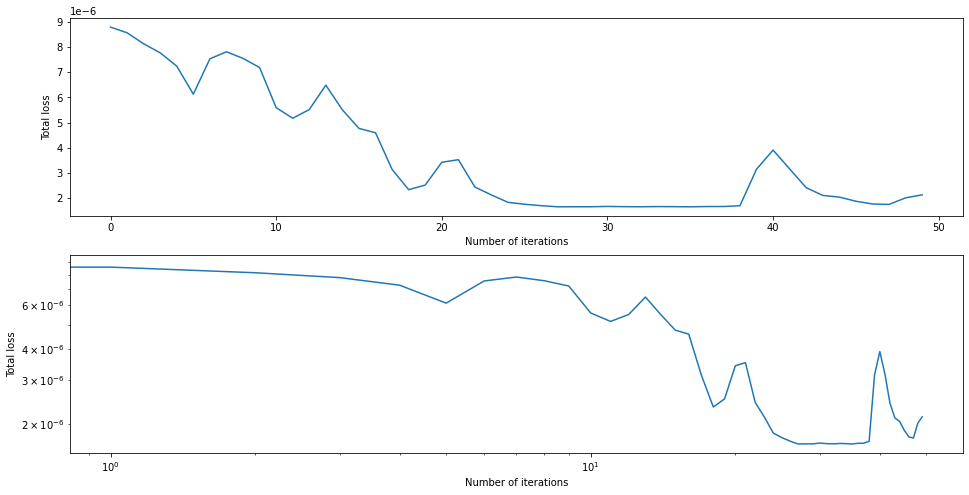

In [459]:

subplot(211)
plot(history.history['loss'])
xlabel('Number of iterations')
ylabel('Total loss');

subplot(212)
loglog(history.history['loss'])
xlabel('Number of iterations')
ylabel('Total loss');

In [460]:
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])
pred_inputs = [train_pos[0:2,:] , tf_packed_SED_data[0:2,:,:]]

expected_outputs = tf_train_stars[0:2,:,:]

predictions = tf_PSF_field_model.predict(x=pred_inputs, batch_size=batch_size)


Text(0.5, 1.0, 'Residual n1 (star-PSF)')

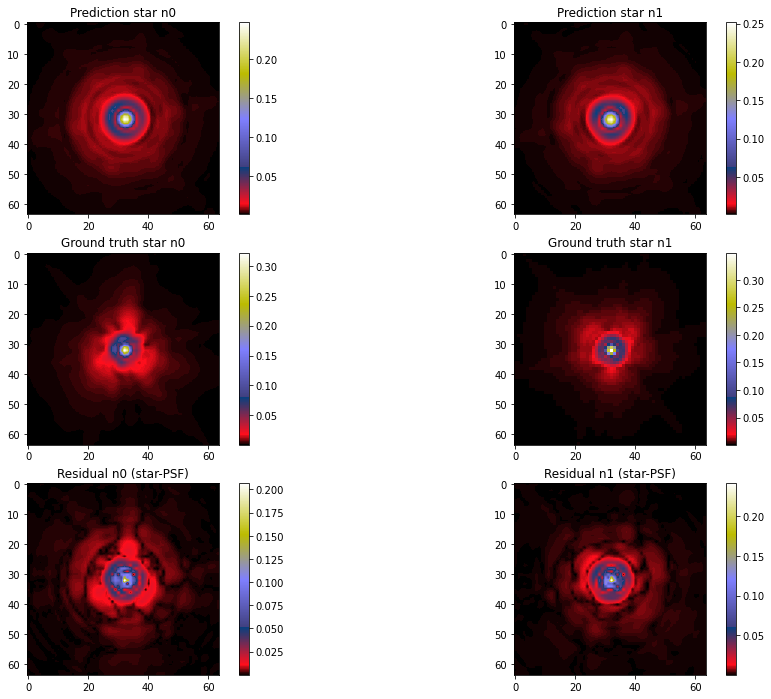

In [461]:
figure(figsize=(16,12))

subplot(321)
imshow(np.sqrt(predictions[0,:,:]), cmap='gist_stern');colorbar()
title('Prediction star n0')

subplot(322)
imshow(np.sqrt(predictions[1,:,:]), cmap='gist_stern');colorbar()
title('Prediction star n1')

subplot(323)
imshow(np.sqrt(expected_outputs[0,:,:]), cmap='gist_stern');colorbar()
title('Ground truth star n0')


subplot(324)
imshow(np.sqrt(expected_outputs[1,:,:]), cmap='gist_stern');colorbar()
title('Ground truth star n1')


subplot(325)
imshow(np.sqrt(abs(expected_outputs[0,:,:] - predictions[0,:,:])), cmap='gist_stern');colorbar()
title('Residual n0 (star-PSF)')


subplot(326)
imshow(np.sqrt(abs(expected_outputs[1,:,:] - predictions[1,:,:])), cmap='gist_stern');colorbar()
title('Residual n1 (star-PSF)')


Text(0.5, 1.0, 'Residual n1 (star-PSF)')

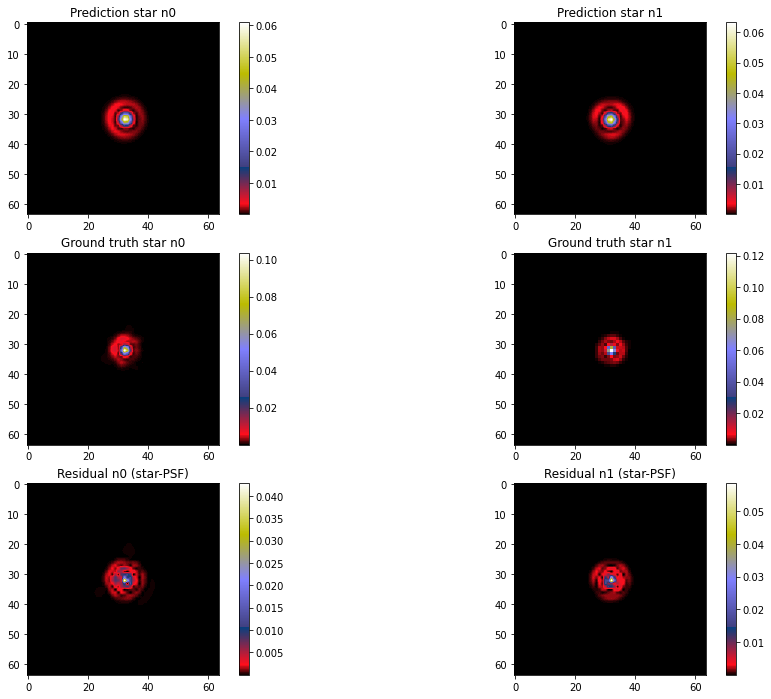

In [462]:
figure(figsize=(16,12))

subplot(321)
imshow(predictions[0,:,:], cmap='gist_stern');colorbar()
title('Prediction star n0')

subplot(322)
imshow(predictions[1,:,:], cmap='gist_stern');colorbar()
title('Prediction star n1')

subplot(323)
imshow(expected_outputs[0,:,:], cmap='gist_stern');colorbar()
title('Ground truth star n0')


subplot(324)
imshow(expected_outputs[1,:,:], cmap='gist_stern');colorbar()
title('Ground truth star n1')


subplot(325)
imshow(abs(expected_outputs[0,:,:] - predictions[0,:,:]), cmap='gist_stern');colorbar()
title('Residual n0 (star-PSF)')


subplot(326)
imshow(abs(expected_outputs[1,:,:] - predictions[1,:,:]), cmap='gist_stern');colorbar()
title('Residual n1 (star-PSF)')